Welcome to the CBC MILP Solver 
Version: 2.10.3 
Build Date: Dec 15 2019 

command line - /Users/myk/Documents/programs/data analytics/Assignment_1_Data_Analytics/venv/lib/python3.11/site-packages/pulp/solverdir/cbc/osx/64/cbc /var/folders/jr/ht0rtnl55hq80pk016rxvhzw0000gn/T/dd6b01f8b8b64c91952b3950df34b59d-pulp.mps -timeMode elapsed -branch -printingOptions all -solution /var/folders/jr/ht0rtnl55hq80pk016rxvhzw0000gn/T/dd6b01f8b8b64c91952b3950df34b59d-pulp.sol (default strategy 1)
At line 2 NAME          MODEL
At line 3 ROWS
At line 205 COLUMNS
At line 33383 RHS
At line 33584 BOUNDS
At line 40221 ENDATA
Problem MODEL has 200 rows, 6636 columns and 13272 elements
Coin0008I MODEL read with 0 errors
Option for timeMode changed from cpu to elapsed
Problem is infeasible - 0.01 seconds
Option for printingOptions changed from normal to all
Total time (CPU seconds):       0.03   (Wallclock seconds):       0.04

Wilcoxon Signed-Rank Test Results:
Pain: p-value = 0.0058
Urgency: p-value = 0.619

/var/folders/jr/ht0rtnl55hq80pk016rxvhzw0000gn/T/ipykernel_3667/3051151222.py:82: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  axs[0].boxplot([matched_results['pain_treated'], matched_results['pain_control']], labels=['Treated', 'Control'])
/var/folders/jr/ht0rtnl55hq80pk016rxvhzw0000gn/T/ipykernel_3667/3051151222.py:88: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  axs[1].boxplot([matched_results['urgency_treated'], matched_results['urgency_control']], labels=['Treated', 'Control'])
/var/folders/jr/ht0rtnl55hq80pk016rxvhzw0000gn/T/ipykernel_3667/3051151222.py:94: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  axs[2].

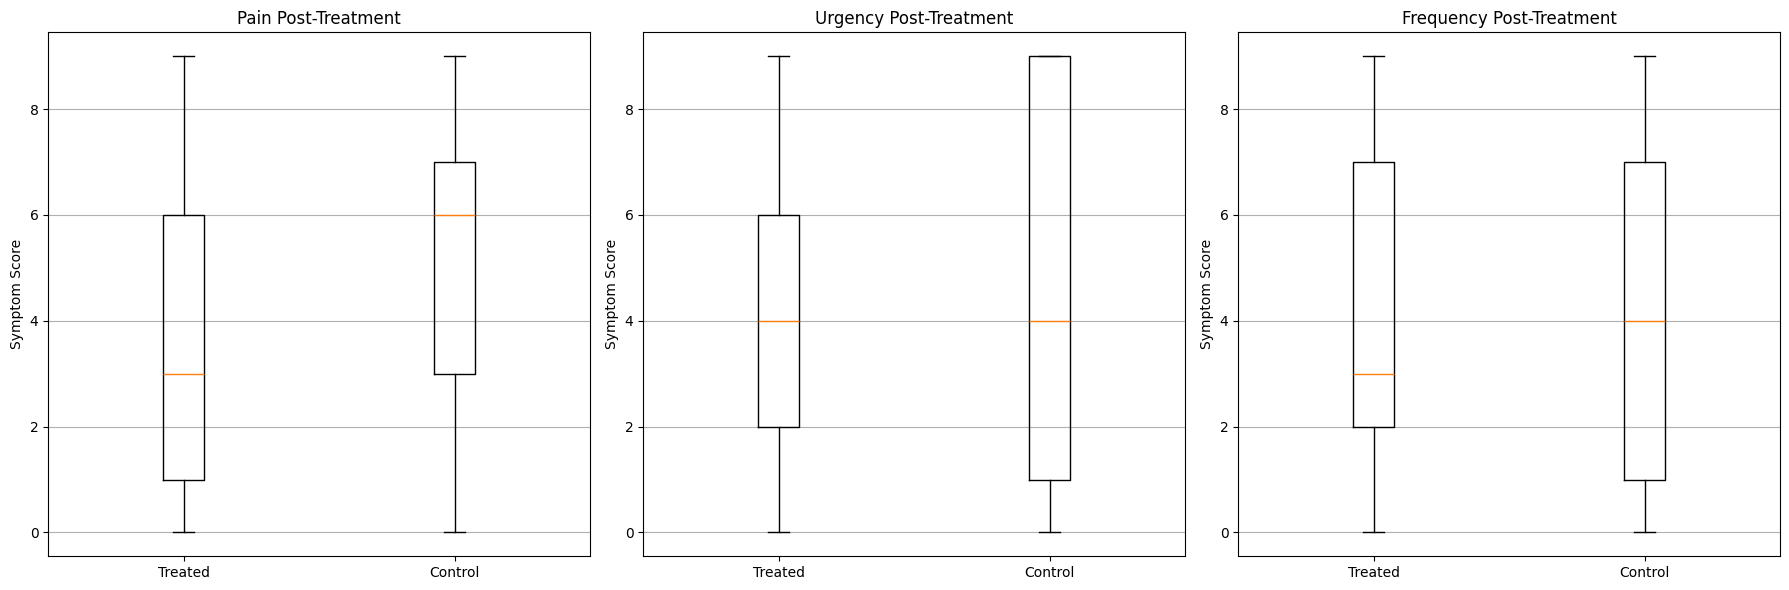

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.spatial import distance
from scipy.stats import wilcoxon
from scipy.linalg import inv
import pulp

# Step 1: Simulate Data (Replace with real dataset)
# We generate a synthetic dataset to simulate patient data with baseline and post-treatment symptoms.
np.random.seed(42)  # For reproducibility
num_patients = 200  # Number of patients in the dataset

# Create a DataFrame with patient data
dataset = pd.DataFrame({
    'patient_id': np.arange(1, num_patients + 1),  # Unique ID for each patient
    'pain_baseline': np.random.randint(0, 10, num_patients),  # Baseline pain score (0-9)
    'urgency_baseline': np.random.randint(0, 10, num_patients),  # Baseline urgency score (0-9)
    'frequency_baseline': np.random.randint(0, 10, num_patients),  # Baseline frequency score (0-9)
    'treatment_time': np.random.choice([3, 6, 9, 12, np.nan], num_patients, p=[0.2, 0.2, 0.2, 0.2, 0.2]),  # Treatment time or NaN if untreated
    'pain_post': np.random.randint(0, 10, num_patients),  # Post-treatment pain score
    'urgency_post': np.random.randint(0, 10, num_patients),  # Post-treatment urgency score
    'frequency_post': np.random.randint(0, 10, num_patients)  # Post-treatment frequency score
})

# Add a column to indicate whether the patient was treated (1) or not (0)
dataset['treated'] = dataset['treatment_time'].notna().astype(int)

# Step 2: Mahalanobis Distance Calculation
# We calculate the Mahalanobis distance between patients based on baseline features.
baseline_features = ['pain_baseline', 'urgency_baseline', 'frequency_baseline']  # Features used for matching
cov_inv = inv(dataset[baseline_features].cov())  # Inverse of the covariance matrix for Mahalanobis distance

def compute_mahalanobis(vec1, vec2):
    """
    Compute the Mahalanobis distance between two vectors.
    :param vec1: First vector (baseline features of patient 1)
    :param vec2: Second vector (baseline features of patient 2)
    :return: Mahalanobis distance between the two vectors
    """
    delta = vec1 - vec2  # Difference between the two vectors
    return np.sqrt(delta.T @ cov_inv @ delta)  # Mahalanobis distance formula

# Step 3: Optimal Matching via Integer Programming
# We use integer programming to find the optimal matching between treated and control patients.
problem = pulp.LpProblem("Patient_Matching", pulp.LpMinimize)  # Define the optimization problem

# Define potential match pairs: treated patients can only be matched with untreated patients
potential_pairs = [(t_idx, c_idx) for t_idx in dataset.index for c_idx in dataset.index
                   if t_idx != c_idx and dataset.loc[t_idx, 'treated'] and not dataset.loc[c_idx, 'treated']]

# Decision variables: Binary variables indicating whether a pair is matched or not
match_decision = {pair: pulp.LpVariable(f"match_{pair[0]}_{pair[1]}", cat='Binary') for pair in potential_pairs}

# Objective function: Minimize the total Mahalanobis distance across all matched pairs
pair_distances = {pair: compute_mahalanobis(dataset.loc[pair[0], baseline_features],
                                            dataset.loc[pair[1], baseline_features])
                  for pair in potential_pairs}
problem += pulp.lpSum(match_decision[pair] * pair_distances[pair] for pair in potential_pairs)

# Constraints:
# 1. Each treated patient must be matched with exactly one control.
# 2. Each control patient can be matched with at most one treated patient.
for idx in dataset.index:
    if dataset.loc[idx, 'treated']:
        problem += pulp.lpSum(match_decision[pair] for pair in potential_pairs if pair[0] == idx) == 1
    else:
        problem += pulp.lpSum(match_decision[pair] for pair in potential_pairs if pair[1] == idx) <= 1

# Solve the optimization problem
problem.solve()

# Step 4: Matched Pairs Extraction
# Extract the matched pairs based on the solution from the integer programming problem
final_matches = [(t, c) for (t, c) in potential_pairs if pulp.value(match_decision[(t, c)]) == 1]

# Create a DataFrame to store the matched results
matched_results = pd.DataFrame([
    (dataset.loc[t, 'pain_post'], dataset.loc[c, 'pain_post'],
     dataset.loc[t, 'urgency_post'], dataset.loc[c, 'urgency_post'],
     dataset.loc[t, 'frequency_post'], dataset.loc[c, 'frequency_post'])
    for t, c in final_matches
], columns=['pain_treated', 'pain_control', 'urgency_treated', 'urgency_control',
            'frequency_treated', 'frequency_control'])

# Step 5: Wilcoxon Signed-Rank Test
# Perform the Wilcoxon signed-rank test to compare the post-treatment outcomes between treated and control groups
pain_stat, pain_pval = wilcoxon(matched_results['pain_treated'], matched_results['pain_control'])
urgency_stat, urgency_pval = wilcoxon(matched_results['urgency_treated'], matched_results['urgency_control'])
frequency_stat, frequency_pval = wilcoxon(matched_results['frequency_treated'], matched_results['frequency_control'])

# Print the results of the Wilcoxon signed-rank test
print("Wilcoxon Signed-Rank Test Results:")
print(f"Pain: p-value = {pain_pval:.4f}")
print(f"Urgency: p-value = {urgency_pval:.4f}")
print(f"Frequency: p-value = {frequency_pval:.4f}")

# Step 6: Visualization
# Create boxplots to visualize the post-treatment outcomes for treated and control groups
fig, axs = plt.subplots(1, 3, figsize=(18, 6))

# Pain Graph
axs[0].boxplot([matched_results['pain_treated'], matched_results['pain_control']], labels=['Treated', 'Control'])
axs[0].set_title('Pain Post-Treatment')
axs[0].set_ylabel('Symptom Score')
axs[0].grid(axis='y')

# Urgency Graph
axs[1].boxplot([matched_results['urgency_treated'], matched_results['urgency_control']], labels=['Treated', 'Control'])
axs[1].set_title('Urgency Post-Treatment')
axs[1].set_ylabel('Symptom Score')
axs[1].grid(axis='y')

# Frequency Graph
axs[2].boxplot([matched_results['frequency_treated'], matched_results['frequency_control']], labels=['Treated', 'Control'])
axs[2].set_title('Frequency Post-Treatment')
axs[2].set_ylabel('Symptom Score')
axs[2].grid(axis='y')

plt.tight_layout()
plt.show()